In [419]:
import pints
import numpy as np
import math
from scipy.constants import N_A
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve, brentq
from numba import njit

In [420]:
#Constants

Target_cell_number = 1e4
E_T_ratio = 1
well_size = 150e-6
sigma = well_size*N_A/Target_cell_number
synapse_gap = 25e-9
synapse_width = 10e-6
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)
tumour_cell_IS_proportion = (synapse_width**2)/(tumour_cell_surface_area)
NK_cell_radius = 3.25e-6
NK_cell_surface_area = 4*math.pi*((NK_cell_radius)**2)
NK_cell_IS_proportion = (synapse_width**2)/NK_cell_surface_area
assay_to_synapse_conversion = (synapse_width**2*synapse_gap)/well_size
sigma_synapse = sigma*assay_to_synapse_conversion
synapse_area = synapse_width**2

A0s = np.geomspace(1e-12, 1e-4, 30)

t_end = 60*60*4
t = np.geomspace(1e-10, t_end, 50)
tspan = [1e-10, t_end]

kon = 1e5
qon = 6.5e3
koff = 1e-4
qoff = 4.7e-3
rtot = 1e5
ftot = 2.2e5
D_t = 1e-14
D_f = 7.4e-14

In [421]:
def A1_steady_state(x, Atot, k1, koff, k2, rtot):
    express = 2*k1*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x))))*(Atot - x - (k2*x*(rtot-x)/(2*(koff + k2*x)))) -koff*x - k2*x*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x)))) +2*koff*(k2*x*(rtot-x)/(2*(koff + k2*x)))

    return express

def A2_steady_state(x, k2, koff, rtot):
    express = k2*x*(rtot-x)/(2*(koff + k2*x))

    return express

#Effector cell opsonization

def effector_A1(ftot, Atot, Q_D):

    a = 1
    b = -(ftot + Atot + Q_D)
    c = ftot*Atot

    return (-b - np.sqrt(b**2 - 4*a*c))/(2*a)

@njit
def S_two_cells(t, z, k1, k2, k3, k4, k5, k6, k7, k1off, k2off, rtot_synapse, rtot_fc_synapse, Atot):


    A0 = Atot - (z[0] + z[1] + z[3] + z[4] + z[2])
    rt = rtot_synapse- z[0] - z[3] - 2*(z[1] + z[4])
    rf = rtot_fc_synapse - z[2] - (z[3] + z[4])
    
    dA10 =  - k2*z[0]*(rt) + 2*1*k1off*z[1] - k4*z[0]*(rf) + 1*k2off*z[3]
    dA20 = k2*z[0]*(rt) - 2*1*k1off*z[1] - k5*z[1]*(rf) + 1*k2off*z[4]
    dA01 =   - 2*k6*1*z[2]*(rt) + k1off*1*z[3]
    dA11 = k4*z[0]*(rf) - 1*k2off*z[3] + 2*k6*1*z[2]*(rt) -k1off*1*z[3] - k7*z[3]*(rt) + 2*1*k1off*z[4]
    dA21 = k5*z[1]*(rf) - 1*k2off*z[4] + k7*z[3]*(rt) - 2*1*k1off*z[4]
    dz = [dA10, dA20, dA01, dA11, dA21]

    return dz

In [422]:
def calc_crosslinks_odes(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot, E_T_ratio, chi):
    
    k2 = 4*D_t/tumour_cell_surface_area
    k1 = kon/sigma
    q1 = qon/sigma
    Q_D = qoff/q1

    Atot = Ainit*sigma
    
    A1_st_sin = fsolve(A1_steady_state, [1e-2], args=(Atot, k1, koff, k2, rtot))
    A2_st_sin = A2_steady_state(A1_st_sin, k2, koff, rtot)
    
        
    Atot = Atot - A1_st_sin - A2_st_sin
    Atot = Atot/E_T_ratio
    A1_E_stst = effector_A1(ftot, Atot, Q_D)
        
    A1_pre_synapse = np.float64(A1_st_sin*tumour_cell_IS_proportion)
    A2_pre_synapse = np.float64(A2_st_sin*tumour_cell_IS_proportion)
    A1_E_pre_synapse = np.float64(A1_E_stst*NK_cell_IS_proportion)
    rtot_synapse = rtot*tumour_cell_IS_proportion
    ftot_synapse = ftot*NK_cell_IS_proportion
    Atot =A1_pre_synapse + A2_pre_synapse + A1_E_pre_synapse
    z_0 = [A1_pre_synapse, A2_pre_synapse, A1_E_pre_synapse, 0, 0]
    k1 = kon/sigma_synapse
    k3 = qon/sigma_synapse
    k2 = 4*D_t/(synapse_area)
    k4 = 2*(D_t +D_f)/(synapse_area)   
    k5 = (2*(D_t +D_f)/(synapse_area))/chi
    k6 = 2*(D_t +D_f)/(synapse_area)  
    k7 = (2*D_t/synapse_area)
    z = solve_ivp(S_two_cells, tspan, z_0, method='BDF',  rtol = 1e-4, atol=1e-3, t_eval=t, args=[k1, k2, k3, k4, k5, k6, k7, koff, qoff, rtot_synapse, ftot_synapse, Atot])
    if z.success == False:
        print(z.message)
    A11 = z.y[3]
    A21 = z.y[4]
  

    crosslinks = (A11[-1] + A21[-1])
    
    
    return crosslinks

In [423]:
@njit
def fc_func(Emax, Efc50, fc):

    return (Emax*(fc/np.max(fc)))/(Efc50 + (fc/np.max(fc)))

def simulate_model(A0s, parameters):
    chi = parameters[0]
    chi = 10**chi
    Efc50 = parameters[1]
    ftot = parameters[2]
    ftot = 10**ftot

    solution = np.zeros_like(A0s)

    for i, Ainit in enumerate(A0s):
        solution[i] = calc_crosslinks_odes(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot, E_T_ratio, chi)
        
    
    solution = fc_func(1, Efc50, solution)
    return solution
    
class model(pints.ForwardModel):

    def n_outputs(self):
         return super().n_outputs()
    
    def n_parameters(self):
        return 3
    
    def simulate(self, parameters, A0s):
        return simulate_model(A0s, parameters)

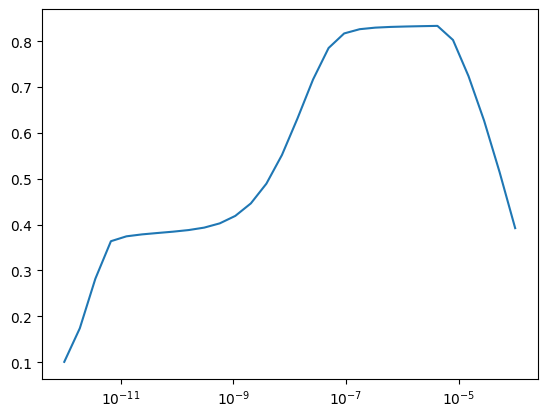

In [424]:
parameters = [5, 0.2, 5]

sol = simulate_model(A0s, parameters)
plt.semilogx(A0s, sol)

Text(0.5, 0, 'Antibody concentration')

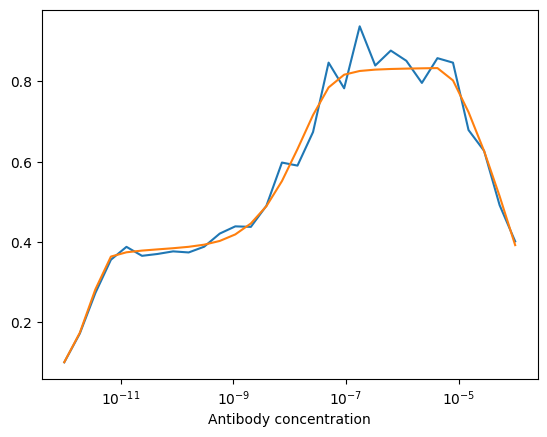

In [425]:
noise = 0.05
values = sol*np.random.normal(1, noise, sol.shape)
#values = values/np.max(values)
plt.semilogx(A0s, values)
plt.semilogx(A0s, sol)
plt.xlabel(r'Antibody concentration')

In [426]:
mod = model()
problem = pints.SingleOutputProblem(mod, A0s, values)
log_likelihood = pints.GaussianLogLikelihood(problem)
parameters += [noise]
print(parameters)
log_prior = pints.UniformLogPrior(
    [4, 0.1, 4, 0.01],
    [6, 1.2, 6, 0.1]
)

log_posterior = pints.LogPosterior(log_likelihood, log_prior)

[5, 0.2, 5, 0.05]


In [427]:
xs = [
    np.array(parameters) * 0.85,
    np.array(parameters) * 0.95,
    np.array(parameters) * 1.05,
    np.array(parameters) * 1.15 
]

In [428]:
mcmc = pints.MCMCController(log_posterior, 4, xs)
mcmc.set_max_iterations(2000)
chains = mcmc.run()

Using Haario-Bardenet adaptive covariance MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:01.7


1     8      0         0         0         0          0:02.4
2     12     0         0         0         0          0:03.2
3     16     0         0         0         0.25       0:04.1
20    84     0.19      0         0.0476    0.143      0:17.2
40    164    0.146     0.0488    0.0488    0.146      0:31.7
60    244    0.0984    0.0492    0.0492    0.115      0:46.8
80    324    0.0864    0.0617    0.037     0.0864     1:00.2
100   404    0.099     0.0495    0.0297    0.0693     1:16.5
120   484    0.0992    0.0413    0.0331    0.0579     1:31.9
140   564    0.0851    0.0426    0.0284    0.0709     1:49.0
160   644    0.0745    0.0373    0.0311    0.0621     2:05.0
180   724    0.0773    0.0331    0.0276    0.0552     2:20.3
Initial phase completed.
200   804    0.0697    0.0348    0.0249    0.0498     2:35.7
220   884    0.109     0.0724    0.0588    0.0905     2:54.3
240   964    0.133     0.0996    0.083     0.112      3:12.2
260   1044   0.149     0.134     0.115     0.137931   3:30.0

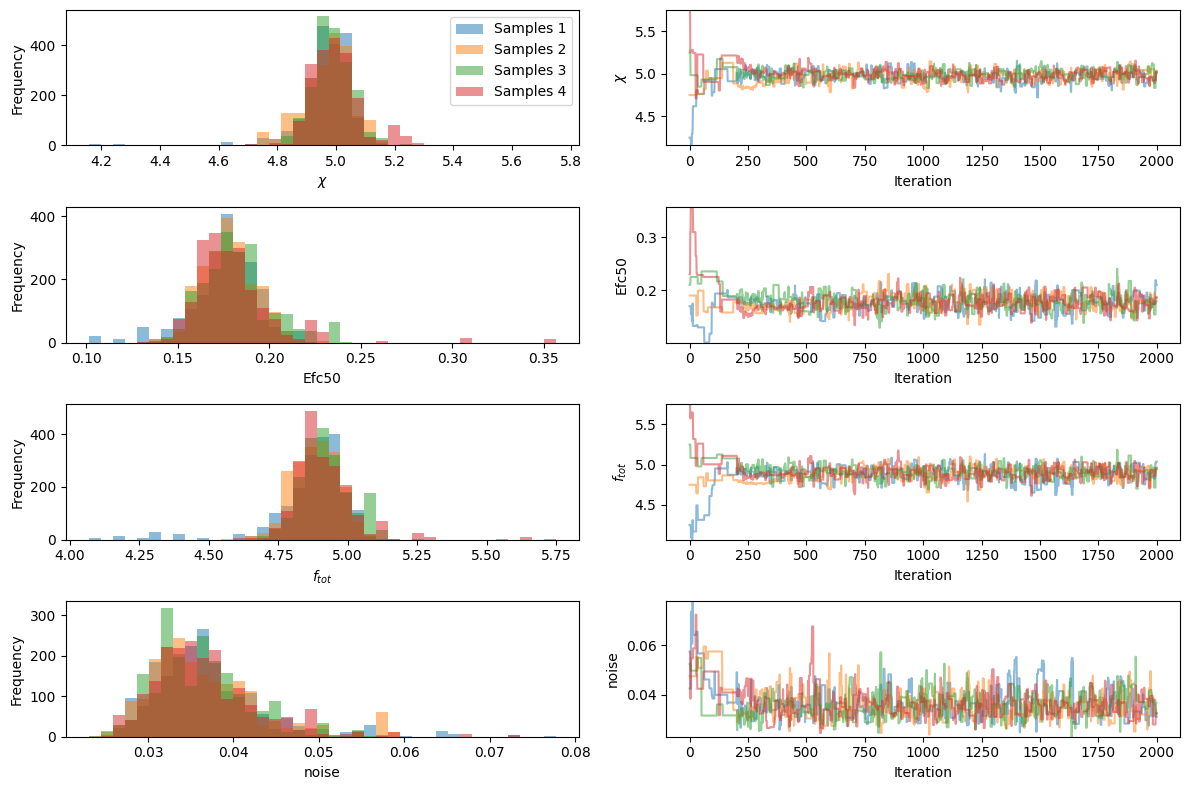

In [429]:
import pints.plot
pints.plot.trace(chains, parameter_names=[r'$\chi$', r'Efc50', r'$f_{tot}$', 'noise'])
plt.show()

In [430]:
chain = chains[0]
chain = chain[350:]

In [431]:
results = pints.MCMCSummary(chains=chains, time=mcmc.time(),parameter_names=[r'$\chi$', r'Efc50', r'$f_{tot}$', 'noise'])
print(results)


param      mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
---------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
$\chi$     4.98    0.09    4.82    4.94   4.98   5.03   5.14     1.03    251.47  0.14
Efc50      0.18    0.02    0.15    0.17   0.18   0.19   0.22     1.03    118.16  0.07
$f_{tot}$  4.90    0.12    4.70    4.84   4.90   4.96   5.08     1.05    83.10   0.05
noise      0.04    0.01    0.03    0.03   0.04   0.04   0.05     1.02    165.02  0.09


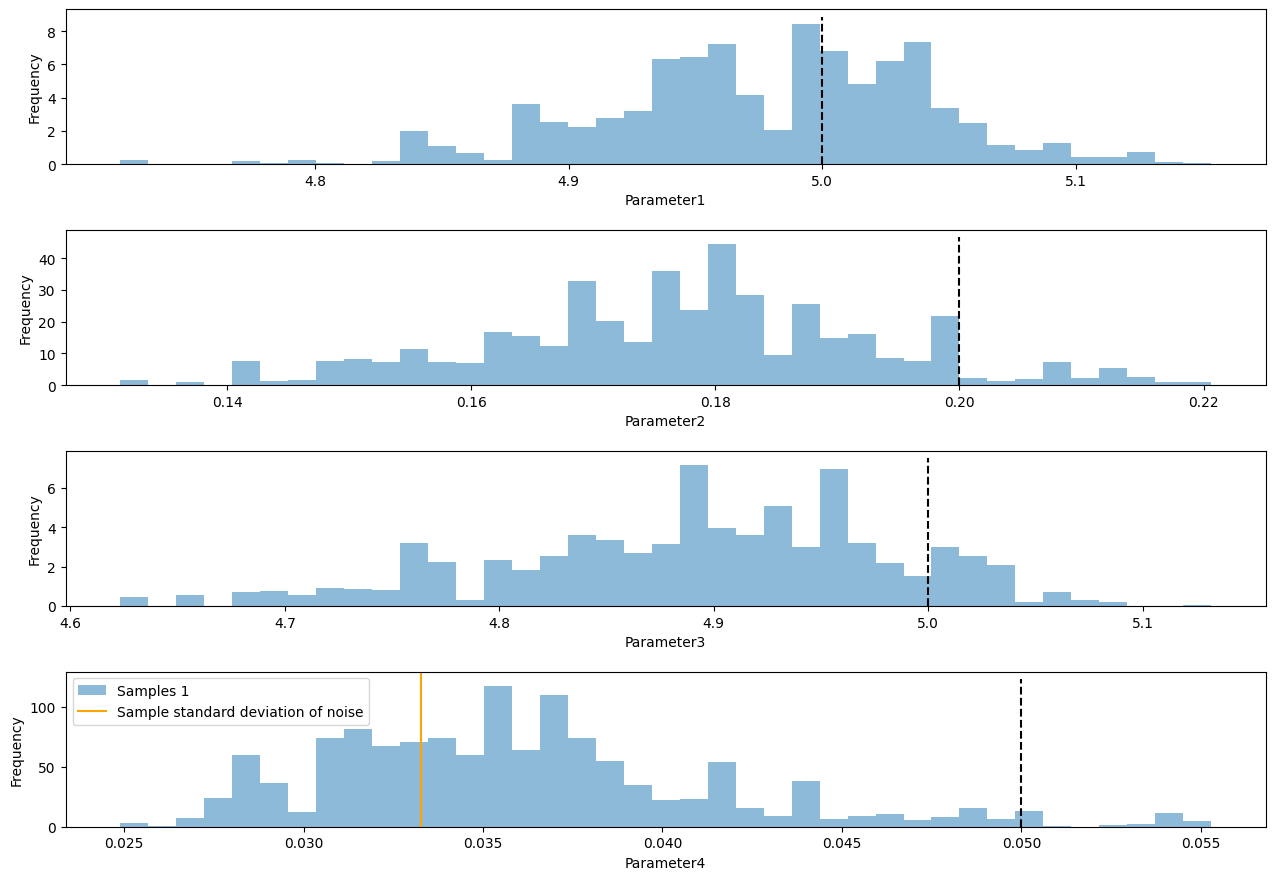

In [432]:
fig, axes = pints.plot.histogram([chain], ref_parameters=parameters)

# Show where the sample standard deviation of the generated noise is:
noise_sample_std = np.std(values - sol)
axes[-1].axvline(noise_sample_std, color='orange', label='Sample standard deviation of noise')
axes[-1].legend()

fig.set_size_inches(14, 9)
plt.show()

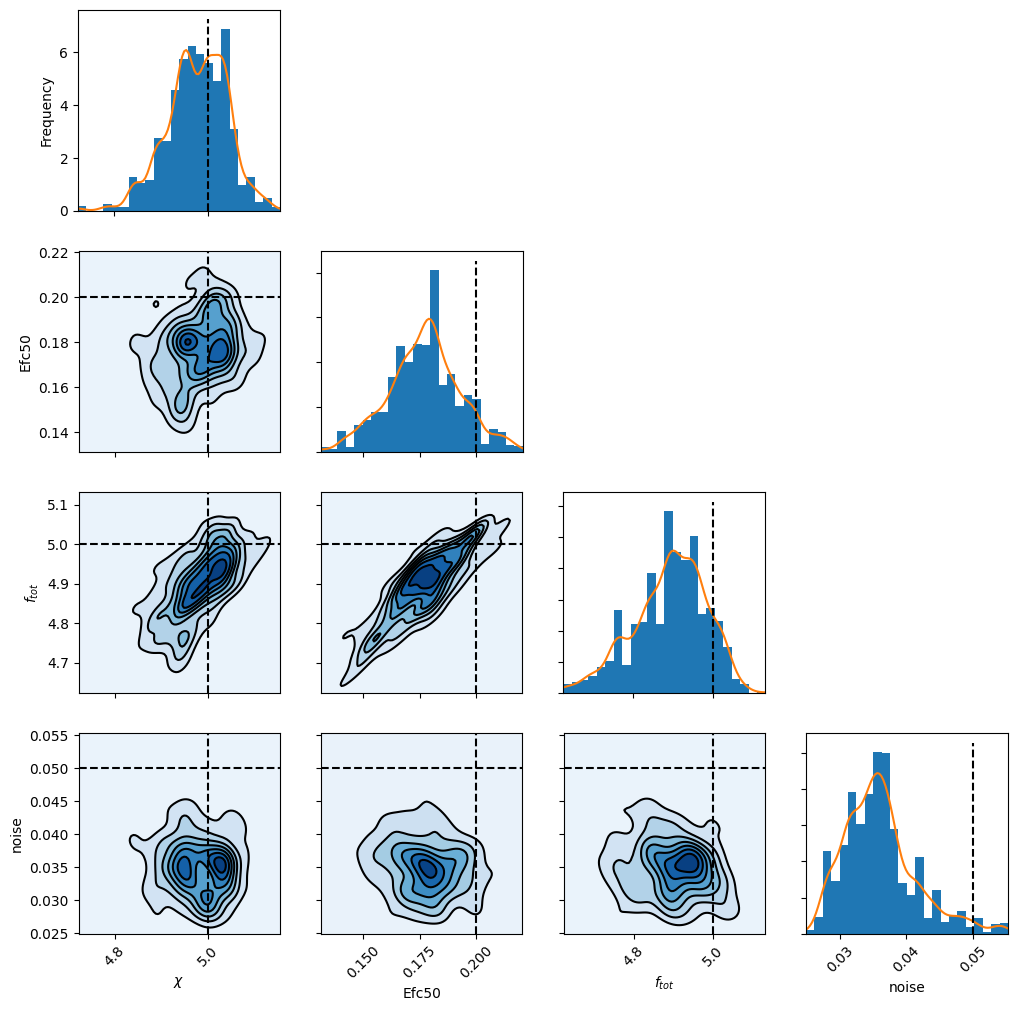

In [433]:
pints.plot.pairwise(chain, kde=True, ref_parameters=parameters,  parameter_names=[r'$\chi$', r'Efc50', r'$f_{tot}$', 'noise'])
plt.show()

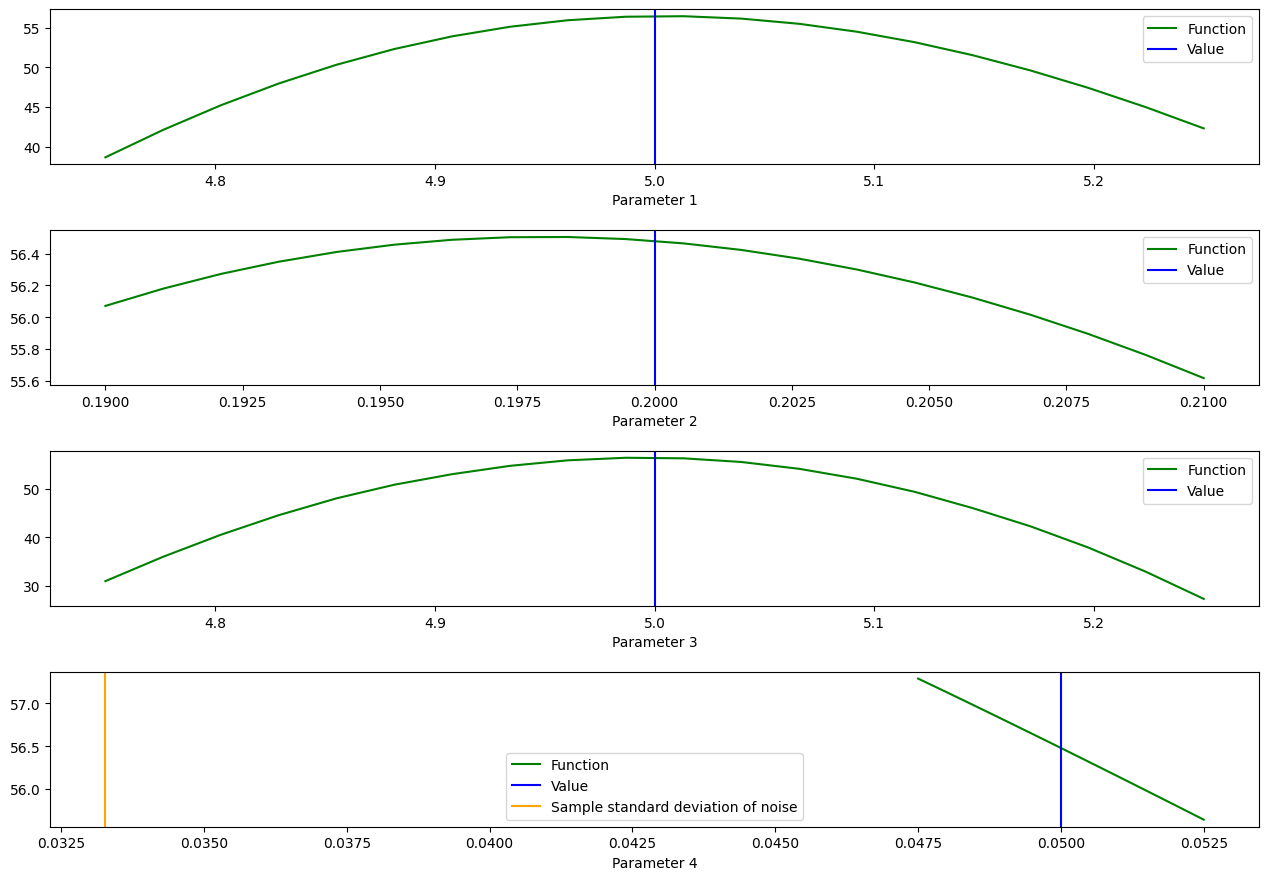

In [434]:
# Plot log-posterior function
fig, axes = pints.plot.function(log_posterior, parameters)

# Add a line showing the sample standard deviation of the generated noise
axes[-1].axvline(noise_sample_std, color='orange', label='Sample standard deviation of noise')
axes[-1].legend()

# Customise the figure size
fig.set_size_inches(14, 9)
plt.show()

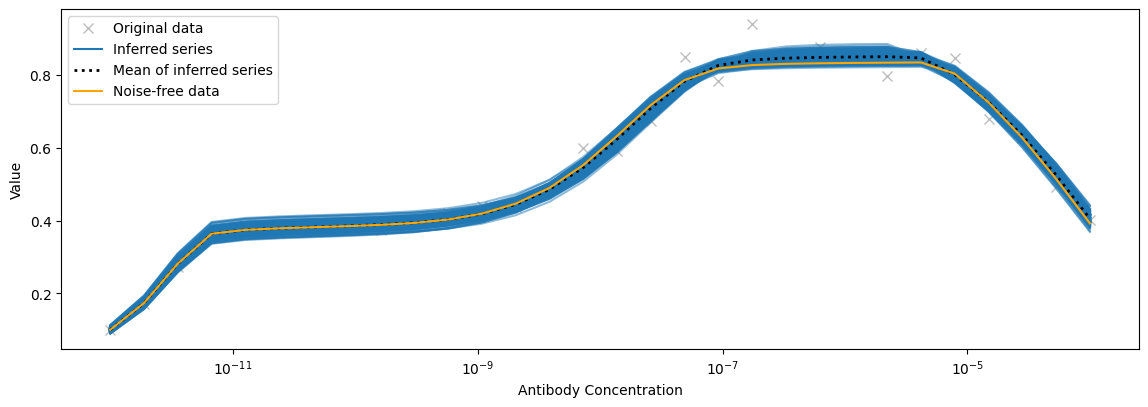

In [435]:
fig, axes = pints.plot.series(chain, problem)

fig.set_size_inches(12,4.5)
plt.plot(A0s, sol, c='orange', label='Noise-free data')
plt.legend()
plt.xscale('log')
plt.xlabel(r'Antibody Concentration')
plt.show()